<a href="https://colab.research.google.com/github/guilhermegranchopro/Prometheus/blob/main/Prometheus/Alpaca/Alpaca2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install alpaca-trade-api

In [ ]:
import yfinance as yf

# Defina o símbolo da empresa
ticker_symbol = 'AAPL'  # Exemplo com Apple

# Obtenha os dados históricos
ticker_data = yf.Ticker(ticker_symbol)
historical_data = ticker_data.history(period='max')

# Obtenha a data da primeira cotação
first_trading_date = historical_data.index[0]
print(f"A empresa {ticker_symbol} começou a ser cotada na bolsa em:", first_trading_date.strftime("%Y-%m-%d"))

def get_start_date(symbol):
    ticker_data = yf.Ticker(symbol)
    historical_data = ticker_data.history(period='max')
    first_trading_date = historical_data.index[0]
    return first_trading_date

A empresa AAPL começou a ser cotada na bolsa em: 1980-12-12


In [ ]:
import pandas as pd
from datetime import datetime, timedelta, timezone

# Obter a data e hora atuais
current_date_time = datetime.now()

# Formatar a data como string
current_date = current_date_time.strftime("%Y-%m-%d")
print(f"Hoje é: {current_date}")

def get_end_date(symbol):
    # Obter a data e hora atuais
    current_date_time = datetime.now()
    # Make start timezone aware
    current_date_time = current_date_time.replace(tzinfo=timezone.utc)
    return current_date_time

Hoje é: 2024-09-01


In [ ]:
import alpaca_trade_api as tradeapi
import pandas as pd
import time
from datetime import datetime, timedelta

def alpaca_autentification():
    # Replace with your Alpaca API credentials
    API_KEY = 'AK1RX6F8W6QX207XPLDF'
    SECRET_KEY = 'WaPoTTxkQBGzC51LajCdyw8Pl6svbINa9eDu9TMK'
    BASE_URL = 'https://api.alpaca.markets'  # Use 'https://api.alpaca.markets' for live trading

    # Initialize the Alpaca API
    api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

    return api

# Function to fetch data in chunks to avoid rate limits
def fetch_data(symbol, start, end, timeframe, api):
    all_data = []
    current_start = start

    while current_start < end:
        current_end = current_start + timedelta(days=7)
        if current_end > end:
            current_end = end

        # Fetch the historical data
        bars = api.get_bars(
            symbol,
            timeframe,
            start=current_start.strftime('%Y-%m-%d'),
            end=current_end.strftime('%Y-%m-%d')
        ).df

        all_data.append(bars)
        current_start = current_end
        time.sleep(1)  # Adjust sleep interval based on rate limits

    return pd.concat(all_data)

In [ ]:
def get_all_data(symbol = 'AAPL', max_period = True, start_date = '', end_date= '', timeframe = '1Min'):
    api = alpaca_autentification()

    if max_period and start_date == '' and end_date == '':
        start_date = get_start_date(symbol)
        end_date = get_end_date(symbol)
    elif start_date != '' and end_date != '':
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    else:
        start_date = datetime(2022, 12, 31)
        end_date = datetime(2023, 12, 31)

    # Fetch the historical data
    apple_data = fetch_data(symbol, start_date, end_date, timeframe, api)
    return apple_data

In [ ]:
# Function to prepare the data
def prepare_data(data, fisrt_marker, second_marker, third_marker):
    # Selecionar colunas relevantes e fazer uma cópia para evitar advertências
    data_selected = data[['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap']].copy()

    # Calcular a média entre 'Open' e 'Close' usando .loc para evitar o SettingWithCopyWarning
    data_selected.loc[:, 'average_oc'] = data_selected[['open', 'close']].mean(axis=1)

    # Calcular a média entre 'High' e 'Low' usando .loc para evitar o SettingWithCopyWarning
    data_selected.loc[:, 'average_hl'] = data_selected[['high', 'low']].mean(axis=1)

    # Selecionar as colunas finais
    if third_marker != '':
        data_final = data_selected[[fisrt_marker, second_marker, third_marker]]
    else:
        data_final = data_selected[[fisrt_marker, second_marker]]

    return data_final

In [ ]:
import numpy as np

# Função para criar as matrizes e os labels
def create_matrices(data_final, n = 12, fisrt_marker = 'volume', second_marker = 'vwap', third_marker = '', relative_fisrt_marker = True, relative_second_marker = False, relative_third_marker = False):
    num_rows = data_final.shape[0]
    num_matrices = num_rows // n  # Número de matrizes completas que podemos formar

    matrices = []
    matrices_y = []

    for i in range(num_matrices):
        start_idx = i * n
        end_idx = start_idx + n
        matrix = data_final.iloc[start_idx:end_idx].copy()

        if relative_fisrt_marker:
            # Calcular a soma da coluna de volume
            volume_sum = matrix[fisrt_marker].sum()

            # Tornar a coluna do volume relativa
            matrix[fisrt_marker] = matrix[fisrt_marker] / volume_sum

            # Converter para valores numpy e adicionar à lista de matrizes
            matrices.append(matrix.values)

        if relative_second_marker:
            # Calcular a soma da coluna de volume
            volume_sum = matrix[second_marker].sum()

            # Tornar a coluna do volume relativa
            matrix[second_marker] = matrix[second_marker] / volume_sum

            # Converter para valores numpy e adicionar à lista de matrizes
            matrices.append(matrix.values)

        if relative_third_marker:
            # Calcular a soma da coluna de volume
            volume_sum = matrix[third_marker].sum()

            # Tornar a coluna do volume relativa
            matrix[third_marker] = matrix[third_marker] / volume_sum

            # Converter para valores numpy e adicionar à lista de matrizes
            matrices.append(matrix.values)

        # Criar labels
        if i > 0:  # Ignorar a primeira matriz para alinhamento correto
            first_value = matrices[i][0, 1]
            last_value = matrices[i][n-1, 1]
            delta = last_value - first_value
            delta_bi = 1 if delta >= 0 else 0
            matrices_y.append(delta_bi)

    return matrices, matrices_y

def sort_matrices(matrices):
    # Ordenar as linhas de cada matriz por ordem decrescente da coluna Average (segunda coluna)
    matrices_x = []
    for matrix in matrices:
        sorted_indices = np.argsort(matrix[:, 1])[::-1]
        sorted_matrix = matrix[sorted_indices]
        matrices_x.append(sorted_matrix)
    return matrices_x

def tensor_creator(matrices_x, matrices_y):
    # Converter listas para arrays numpy
    matrices_x = np.array(matrices_x)
    matrices_y = np.array(matrices_y)
    return matrices_x, matrices_y

In [ ]:
def get_dataset(company_data, n_rows, sort = True, fisrt_marker = 'volume', second_marker = 'vwap' ,
                third_marker = '', relative_fisrt_marker = True, relative_second_marker = False,
                relative_third_marker = False, decimals = ''):
    matrices_x = []
    matrices_y = []

    matrices_x, matrices_y = create_matrices(company_data, n_rows, fisrt_marker, second_marker, third_marker, relative_fisrt_marker, relative_second_marker, relative_third_marker)

    if sort:
        matrices_x = sort_matrices(matrices_x)

    # Remover a última matriz de matrices_x para alinhamento com matrices_y
    if matrices_x:
        matrices_x.pop()

    matrices_x, matrices_y = tensor_creator(matrices_x, matrices_y)

    if decimals != '':
        matrices_x = np.round(matrices_x, decimals = decimals)
    return matrices_x, matrices_y

In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset(matrices_x, matrices_y, LSTM = True):

    if LSTM:
        # Total de amostras
        n_samples = matrices_x.shape[0]

        # Índices para divisão
        train_size = int(0.6 * n_samples)  # 60% para treino
        val_size = int(0.2 * n_samples)    # 20% para validação
        test_size = n_samples - train_size - val_size  # 20% para teste

        # Dividir os dados sequencialmente
        X_train = matrices_x[:train_size]
        y_train = matrices_y[:train_size]

        X_val = matrices_x[train_size:train_size + val_size]
        y_val = matrices_y[train_size:train_size + val_size]

        X_test = matrices_x[train_size + val_size:]
        y_test = matrices_y[train_size + val_size:]
    else:
        # Dividir os dados em conjuntos de treinamento + validação e teste
        X_train_val, X_test, y_train_val, y_test = train_test_split(matrices_x, matrices_y, test_size=0.2, random_state=42)

        # Dividir o conjunto de treinamento + validação em treinamento e validação
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# Função para construir a rede neural
def build_model(input_shape, LSTM_boolean=True):
    warnings.filterwarnings('ignore', category=UserWarning, module='keras')
    model = Sequential()

    if LSTM_boolean:
        model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.2))
    else:
        model.add(Flatten(input_shape=input_shape))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    # Compilando o modelo com uma taxa de aprendizado ajustada
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
def model_training(model, X_train, X_val, X_test, y_train, y_val, y_test, epochs=5, early_stopping = True, call_back = 'val_accuracy', patience = 2, batch_size=32):

    # Treinar o modelo
    print("Treinando o modelo...")

    if early_stopping:
        early_stopping = EarlyStopping(monitor=call_back, patience=patience, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])
    else:
        history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val))

    print()

    # Avaliar o modelo nos dados de teste
    print("Avaliação no conjunto de teste:")
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    return model, history, test_loss, test_accuracy

In [ ]:
# Plotar a precisão e a perda ao longo das épocas
import matplotlib.pyplot as plt

def graphics_analysis(history):

    # Precisão
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Perda
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

As primeiras possibilidades de cada variável são aquelas as quais inicialmnete pensas-te que faziam mais sentido:

* symbol = 'AAPL', (retira do ficheito execel, tens o código que extrai)
* max_period = True, (podes ter erros por excesso de pedidos do API)
* start_date = '', '2022-10-31', (1 ano funciona bem para test runs)
* end_date = '', '2023-10-31', (1 ano funciona bem para test runs)
* timeframe = '1Min', '5Min', (mais de 5Min parece perder sentido a teoria)
* fisrt_marker = 'volume', 'close', 'high', 'low', 'trade_count', 'open', 'vwap', 'average_oc', 'average_hl', (a ideia inicial é ver o volume relativo, mas pode ser interessante estudar o trade_count)
* second_marker = 'vwap', 'volume', 'close', 'high', 'low', 'trade_count', 'open', 'average_oc', 'average_hl', (a ideia inicial era ver a média entre o high e o low - 'average_hl', mas fica na duvida ver a média entre o open e o close - 'average_oc', pode também ser muito interessante investigar o vwap)
* third_marker = '', 'volume', 'close', 'high', 'low', 'trade_count', 'open', 'vwap', 'average_oc', 'average_hl', (não pensas te em usar uma terceira coluna para criar as matrizes, mas se os resultados impiricos assim o provarem usa)
* n_rows = 12, 10, 15, 30, 5, (pensa no timeframe quando fazes isso, o 12 pareceu ser o melhor em testes impiricos)
* sort = True, (tens de pensar na sequencia temporal se faz sentido manter ou não)
* relative_first_marker = True, (tens de pensar em que marker correspondente estás a usar, pensa se matemáticamente faz sentido ou não colocares o marcador com valores relativos para todo o tensor, faltam te dados impiricos, o volume pensas te inicialmnete deixar em impirico para o tensor para normalizares os tensores)
* relative_second_marker = False, (tens de pensar em que marker correspondente estás a usar, pensa se matemáticamente faz sentido ou não colocares o marcador com valores relativos para todo o tensor, faltam te dados impiricos)
* relative_third_marker = False, (tens de pensar em que marker correspondente estás a usar, pensa se matemáticamente faz sentido ou não colocares o marcador com valores relativos para todo o tensor, faltam te dados impiricos)
* decimals = '', 3, 4 (tens de ver o que os dados impiricos te dizem se com arrendondamentos facilitas ou n a vida do AI)
* LSTM_boolean = True, (em caso de falso não usas um LSTM e partes do precipio que a relação causal deixa de ser importante para a cosntrução do tensor, quando normalizas os dados a esperança seria de não teres de usar um LSTM)
* epochs = 5, (este numero tende a ser irrelevante porque tens um checkpoint de callback referente ao melhor resultado de validation accuracy)
* early_stopping = True, (podes ligar ou desligar de forma automática o early_stopping, ou seja, o call back aqui)
* call_back = 'val_accuracy', 'val_loss', 'accuracy', 'loss' (escolhes o paramtero que monitora o call back)
* patience = 2, 50, 100, 500, 1000 (escolhes a paciencia do call back)
* batch_size = 64, 16, 32, 128, 256, 512 (varias com o tramanho do dataset, mas pensa que tens conseguido datasets bem grandes portanto usa os maiores valores)

In [ ]:
symbol = 'AAPL'
max_period = True
start_date = '2022-10-31'
end_date = '2023-12-31'
timeframe = '1Min'
fisrt_marker = 'volume'
second_marker = 'vwap'
third_marker = ''
n_rows = 12
sort = True
relative_first_marker = True
relative_second_marker = False
relative_third_marker = False
decimals = ''
LSTM_boolean = True
epochs = 5
early_stopping = True
call_back = 'val_accuracy'
patience = 2
batch_size = 64

In [ ]:
company_data = get_all_data(symbol, max_period, start_date, end_date, timeframe)

print(company_data)
print(company_data.shape)
print()

                              close      high       low  trade_count  \
timestamp                                                              
2022-10-31 08:00:00+00:00  154.8000  155.6600  154.5400          157   
2022-10-31 08:01:00+00:00  154.8600  154.8600  154.7400           47   
2022-10-31 08:02:00+00:00  154.7500  154.7800  154.7500           70   
2022-10-31 08:03:00+00:00  154.7000  154.7500  154.6700          122   
2022-10-31 08:04:00+00:00  154.6900  154.7500  154.6900          104   
...                             ...       ...       ...          ...   
2023-12-30 00:55:00+00:00  192.2400  192.2400  192.2400           15   
2023-12-30 00:56:00+00:00  192.2300  192.2300  192.2300           15   
2023-12-30 00:57:00+00:00  192.2200  192.2300  192.2200           15   
2023-12-30 00:58:00+00:00  192.1000  192.2200  192.1000           32   
2023-12-30 00:59:00+00:00  192.1501  192.1505  192.1501           12   

                               open  volume        vwap  
times

In [ ]:
company_data = prepare_data(company_data, fisrt_marker, second_marker, third_marker)

print(company_data)
print(company_data.shape)
print()

                           volume        vwap
timestamp                                    
2022-10-31 08:00:00+00:00   10455  154.930632
2022-10-31 08:01:00+00:00    3084  154.806910
2022-10-31 08:02:00+00:00    2291  154.763549
2022-10-31 08:03:00+00:00   12671  154.704598
2022-10-31 08:04:00+00:00    7064  154.712889
...                           ...         ...
2023-12-30 00:55:00+00:00     717  192.237197
2023-12-30 00:56:00+00:00     532  192.229964
2023-12-30 00:57:00+00:00     662  192.225242
2023-12-30 00:58:00+00:00    2154  192.172983
2023-12-30 00:59:00+00:00    2147  192.151211

[260125 rows x 2 columns]
(260125, 2)



In [ ]:
matrices_x, matrices_y = get_dataset(company_data, n_rows, sort, fisrt_marker, second_marker , third_marker, relative_first_marker, relative_second_marker, relative_third_marker, decimals)

print(matrices_x)
print(matrices_x.shape)
print(matrices_y)
print(matrices_y.shape)
print()

[[[1.54276355e-01 1.54930632e+02]
  [4.55082045e-02 1.54806910e+02]
  [9.71254870e-02 1.54763809e+02]
  ...
  [1.86976154e-01 1.54704598e+02]
  [5.51292645e-02 1.54692987e+02]
  [5.43471845e-02 1.54667537e+02]]

 [[3.36043669e-02 1.54863587e+02]
  [4.30431569e-02 1.54798164e+02]
  [9.93915961e-02 1.54793272e+02]
  ...
  [1.29982373e-01 1.54739055e+02]
  [1.38625121e-01 1.54715238e+02]
  [1.09285268e-01 1.54700239e+02]]

 [[6.54518223e-02 1.54846087e+02]
  [1.05441837e-01 1.54824484e+02]
  [7.36894658e-02 1.54799472e+02]
  ...
  [3.67948078e-02 1.54528060e+02]
  [2.40888667e-01 1.54505602e+02]
  [5.37194209e-02 1.54451180e+02]]

 ...

 [[2.96650718e-02 1.92239194e+02]
  [5.37081340e-02 1.92229310e+02]
  [2.90669856e-02 1.92224733e+02]
  ...
  [3.10526316e-01 1.92163871e+02]
  [8.15789474e-02 1.92162654e+02]
  [6.39952153e-02 1.92156327e+02]]

 [[2.53869969e-02 1.92189146e+02]
  [6.68730650e-02 1.92169221e+02]
  [3.34365325e-02 1.92168935e+02]
  ...
  [3.62074303e-01 1.92145452e+02]
  [4

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(matrices_x, matrices_y, LSTM)

# Exibir as formas dos arrays resultantes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print()

Shape of X_train: (13005, 12, 2)
Shape of y_train: (13005,)
Shape of X_val: (4335, 12, 2)
Shape of y_val: (4335,)
Shape of X_test: (4336, 12, 2)
Shape of y_test: (4336,)



In [ ]:
if third_marker == '':
  input_shape = (n_rows, 2)
else:
  input_shape = (n_rows, 3)
model = build_model(input_shape, LSTM_boolean)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 12, 64)              │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model, history, test_loss, test_accuracy = model_training(model, X_train, X_val, X_test, y_train, y_val, y_test, epochs, early_stopping, call_back, patience, batch_size)

Treinando o modelo...
Epoch 1/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5000 - loss: 0.7006 - val_accuracy: 0.5006 - val_loss: 0.6932
Epoch 2/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4991 - loss: 0.6954 - val_accuracy: 0.5006 - val_loss: 0.6933
Epoch 3/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4996 - loss: 0.6941 - val_accuracy: 0.5006 - val_loss: 0.6933

Avaliação no conjunto de teste:
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4967 - loss: 0.6933


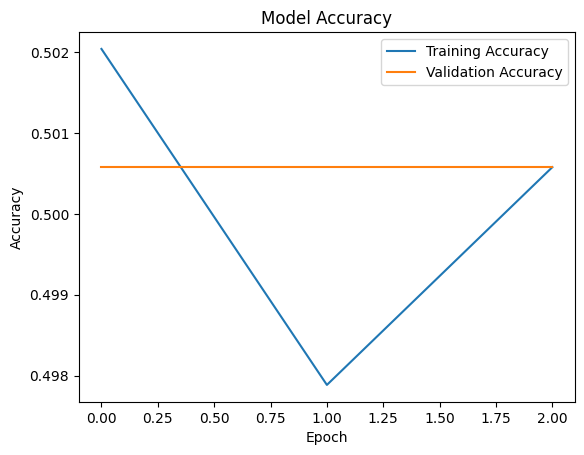

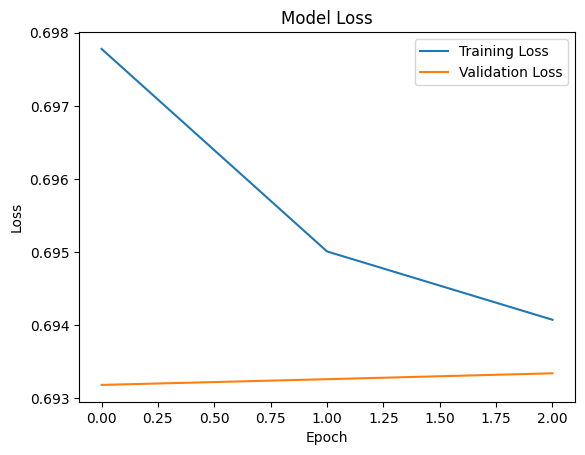

In [ ]:
graphics_analysis(history)

In [ ]:
from google.colab import drive
import os

# Montar o Google Drive
drive.mount('/content/drive')
print()

# Defina o caminho do diretório no Google Drive
caminho_para_salvar = '/content/drive/MyDrive/AI Financial Analisys/Summer Project/Neural Network/Models'

# Verifique se o diretório existe, caso contrário, crie-o
if not os.path.exists(caminho_para_salvar):
    print(f"O dirétório {caminho_para_salvar} não existe.")

model_name = 's=' + symbol + '_' + 'mp=' + str(max_period) + '_' + 'sd=' + \
start_date + '_' + 'ed=' + end_date + '_' + 'tf=' + timeframe + '_' + \
'fm=' + fisrt_marker + '_' + 'sm=' + second_marker + '_' + \
'tm=' + third_marker + '_' + 'r=' + str(n_rows) + '_' + \
's=' + str(sort) + '_' + 'rfm=' + str(relative_first_marker) + '_' + \
'rsm=' + str(relative_second_marker) + '_' + \
'rtm=' + str(relative_third_marker) + '_' + \
'd=' + decimals + '_' + 'Lb=' + str(LSTM_boolean) + '_' + 'e=' + str(epochs) + '_' + \
'es=' + str(early_stopping) + '_' + 'cb=' + call_back + '_' + \
'p=' + str(patience) + '_' + 'bs=' + str(batch_size) + '_' + \
'tl=' + str(test_loss) + '_' + 'ta=' + str(test_accuracy)

caminho_completo = os.path.join(caminho_para_salvar, model_name + '.keras')

# Salva o modelo em formato
model.save(caminho_completo)

print("Ficheiro do Modelo:")
print(model_name + '.keras')
print()
print("Modelo salvo em:")
print(caminho_para_salvar)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Ficheiro do Modelo:
s=AAPL_mp=True_sd=2022-10-31_ed=2023-12-31_tf=1Min_fm=volume_sm=vwap_tm=_r=12_s=True_rfm=True_rsm=False_rtm=False_d=_Lb=True_e=5_es=True_cb=val_accuracy_p=2_bs=64_tl=0.6933699250221252_ta=0.49054428935050964.keras

Modelo salvo em:
/content/drive/MyDrive/AI Financial Analisys/Summer Project/Neural Network/Models
